In [1]:
%matplotlib inline
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense,Activation,GlobalAveragePooling2D,Lambda,Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils

from tensorflow.keras.applications.vgg19 import VGG19, preprocess_input

from sklearn.metrics import confusion_matrix
import itertools
import os
import shutil
import random
import matplotlib.pyplot as plt


2022-03-29 15:10:34.497353: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-03-29 15:10:34.497381: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
train_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/train"
test_path = r"/mnt/sda2/Final_year_project/btd_final_project/cnn_models/data_2/test"


In [3]:
train_batches  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(train_path,target_size=[128,128],batch_size=30)
test_batches  = ImageDataGenerator(preprocessing_function=preprocess_input).flow_from_directory(test_path,target_size=[128,128],batch_size=20)

Found 2400 images belonging to 2 classes.
Found 600 images belonging to 2 classes.


In [4]:
vgg = VGG19(weights='imagenet',include_top=False)

for layer in vgg.layers:
     layer.trainable = False

2022-03-29 15:10:37.248046: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-29 15:10:37.248090: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-29 15:10:37.248114: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (machine): /proc/driver/nvidia/version does not exist
2022-03-29 15:10:37.248353: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
x = vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(128,activation='relu')(x)
x = Dense(64,activation='relu')(x)
x = Dense(32,activation='relu')(x)
preds = Dense(2,activation='softmax')(x)

model = Model(inputs=vgg.input, outputs=preds)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

In [6]:
model.compile(
     loss='binary_crossentropy',
     optimizer='adam',
     metrics=['accuracy']
)

In [7]:
history = model.fit(train_batches,validation_data=test_batches,epochs=10)

Epoch 1/10
80/80 [==============================] - 229s 3s/step - loss: 0.4461 - accuracy: 0.8263 - val_loss: 0.2130 - val_accuracy: 0.9183
Epoch 2/10
80/80 [==============================] - 233s 3s/step - loss: 0.1693 - accuracy: 0.9371 - val_loss: 0.1397 - val_accuracy: 0.9533
Epoch 3/10
80/80 [==============================] - 233s 3s/step - loss: 0.0957 - accuracy: 0.9712 - val_loss: 0.1219 - val_accuracy: 0.9617
Epoch 4/10
80/80 [==============================] - 232s 3s/step - loss: 0.0531 - accuracy: 0.9875 - val_loss: 0.1440 - val_accuracy: 0.9533
Epoch 5/10
80/80 [==============================] - 233s 3s/step - loss: 0.0355 - accuracy: 0.9892 - val_loss: 0.1012 - val_accuracy: 0.9700
Epoch 6/10
80/80 [==============================] - 233s 3s/step - loss: 0.0436 - accuracy: 0.9871 - val_loss: 0.1241 - val_accuracy: 0.9683
Epoch 7/10
80/80 [==============================] - 234s 3s/step - loss: 0.0215 - accuracy: 0.9942 - val_loss: 0.1322 - val_accuracy: 0.9667
Epoch 8/10
80

In [10]:
def tr_plot(tr_data, start_epoch):
    #Plot the loss and accuracy curve
    tacc=tr_data.history['accuracy']
    tloss=tr_data.history['loss']
    vacc=tr_data.history['val_accuracy']
    vloss=tr_data.history['val_loss']
    Epoch_count=len(tacc)+ start_epoch
    Epochs=[]
    for i in range (start_epoch ,Epoch_count):
        Epochs.append(i+1)
    index_loss=np.argmin(vloss)#  this is the epoch with the lowest validation loss
    val_lowest=vloss[index_loss]
    index_acc=np.argmax(vacc)
    acc_highest=vacc[index_acc]
    plt.style.use('fivethirtyeight')
    sc_label='best epoch= '+ str(index_loss+1 +start_epoch)
    vc_label='best epoch= '+ str(index_acc + 1+ start_epoch)
    fig,axes=plt.subplots(nrows=1, ncols=2, figsize=(20,8))
    axes[0].plot(Epochs,tloss, 'orange', label='Training loss')
    axes[0].plot(Epochs,vloss,'blue',label='Validation loss' )
    axes[0].scatter(index_loss+1 +start_epoch,val_lowest, s=150, c= 'blue', label=sc_label)
    axes[0].set_title('Training and Validation Loss')
    axes[0].set_xlabel('Epochs')
    axes[0].set_ylabel('Loss')
    axes[0].legend()
    axes[1].plot (Epochs,tacc,'orange',label= 'Training Accuracy')
    axes[1].plot (Epochs,vacc,'blue',label= 'Validation Accuracy')
    axes[1].scatter(index_acc+1 +start_epoch,acc_highest, s=150, c= 'blue', label=vc_label)
    axes[1].set_title('Training and Validation Accuracy')
    axes[1].set_xlabel('Epochs')
    axes[1].set_ylabel('Accuracy')
    axes[1].legend()
    plt.tight_layout

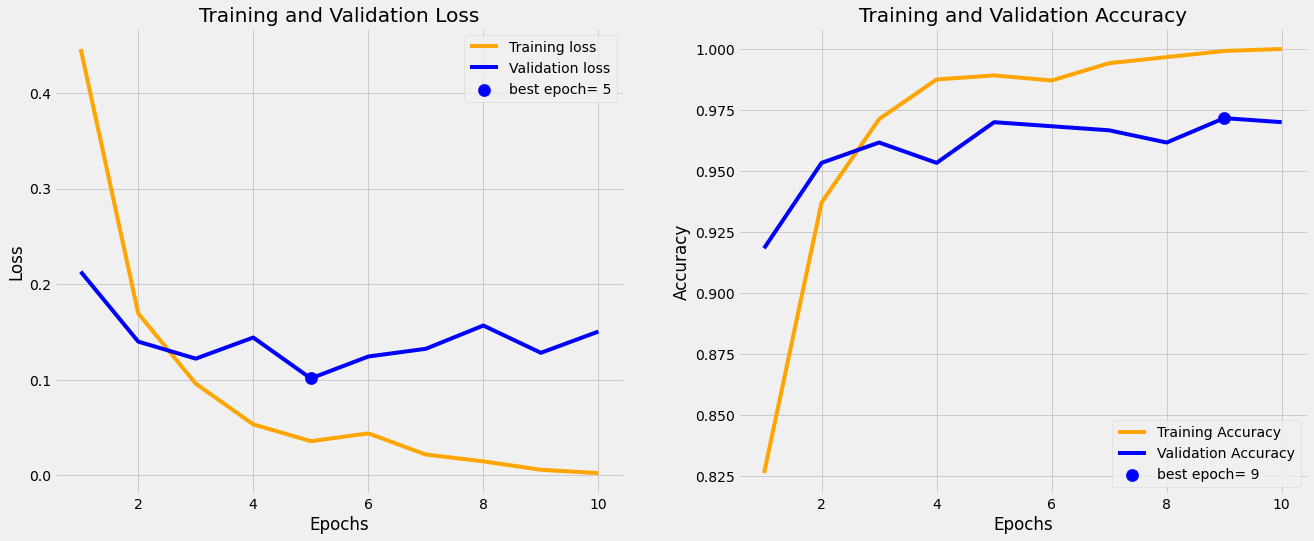

In [11]:
tr_plot(history,0)
plt.savefig('VGG19_V2_epoch2_10_batch_size_30_final.png')

